In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np


In [2]:
def draw_weights(weights):
    #if fig is None:
    fig = plt.figure(figsize=(12.9,10))
    pxl_x = 30
    pxl_y = 30
    n_units, _ = weights.shape

    all_weights = np.zeros((pxl_y*n_units,pxl_x))
    print(all_weights.shape)

    # iterate over units
    for unit in range(n_units):
        all_weights[unit*pxl_y:(unit+1)*pxl_y, :] = weights[unit,:].reshape(pxl_y,pxl_x)

    abs_max = np.amax(np.absolute(all_weights))
    im = plt.imshow(all_weights, cmap='bwr', vmin=-abs_max, vmax=abs_max)
    fig.colorbar(im, ticks=[np.amin(all_weights), 0, np.amax(all_weights)])
    plt.axis('off')
    plt.title(f"Weights at epoch: {epoch+1}")

    fig.canvas.draw()   
    display(fig)
    clear_output(wait=True)
    fig.clear()
    plt.close(fig)

In [3]:
def selectivity_metric(activity):
    print(activity.shape)
    print(torch.mean(activity, dim=1))
    s =  1 - torch.mean(activity, dim=1)/torch.max(activity, dim=1).values # calc selectivity per neuron -> go row wise over batch
    # print(s)
    # print(s.shape)
    # s = torch.mean(s, dim=1) # take avg of selectivity over entire batch
    return s


In [4]:
class BCM_Model(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        self.weights = torch.normal( mean=0, std=1, size=(n_units, n_in),dtype=torch.float64)
        self.threshold = torch.zeros(n_units)
        self.threshold_view = torch.reshape(self.threshold, (n_units,1)).expand(-1, batch_size) 
        self.act = lambda y: y *(y - self.threshold_view)
       # self.linear_act = 
       # self.act = nn.Sigmoid()
        # for visu
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []

    def forward(self, x):
        y = self.act(torch.mm(self.weights, x))
        return y
    
    def update(self, x, eps=1, dt=0.02):
        # update threshold
        y = torch.mm(self.weights, x)
        self.threshold = torch.mean(y, dim=1)

        # update weights
        act = self.act(y)
        delta_w = (torch.mm(act,x.T) - eps * self.weights)* dt
        self.weights += delta_w

        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

In [5]:
# Squadrani et al version

class BCM_Model_Squadrani(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        self.weights = torch.normal( mean=0, std=1, size=(n_units, n_in),dtype=torch.float64)
        self.threshold = torch.zeros(n_units)

        self.threshold_view = torch.reshape(self.threshold, (n_units,1)).expand(-1, batch_size)   
       # self.act = lambda y: y *(y - self.threshold_view)
        self.act = nn.ReLU()
        # for visu
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []

    def forward(self, x):
        y = self.act(torch.mm(self.weights, x))
        return y
    
    def update(self, x, gamma=0.5, eps=0.05):

        # forward pass
        y = self.act(torch.mm(self.weights, x))

        # calc current threshold 
        cur_threshold = torch.mean(y**2, dim=1) # avg over batch 

        # update threshold using moving avg & last + current threshold
        self.threshold = gamma*self.threshold + (1-gamma) * cur_threshold

        # calc delta W
        t  = self.threshold.reshape(-1, 1)
        delta_w = torch.einsum('ij, jk -> ik', (y * ( y - t ) ) / t , x.T)
        delta_w /= x.shape[1] # normalize the weights update according to the number of samples
        

       # print("eh",x.shape[1])
        # weight decay
        # if self.decay != 0:
        #     delta_w -= self.decay * self.weights

        # update weights
        self.weights +=  eps* delta_w 

        

        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

In [6]:
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape
data.shape

torch.Size([400, 900])

torch.Size([10, 100])
tensor([5.1588e+25, 4.7731e+25, 1.0250e+26, 1.1064e+26, 1.2382e+28, 1.4021e+25,
        1.7626e+25, 1.7639e+27, 1.6278e+25, 7.3754e+23], dtype=torch.float64)
(300, 30)


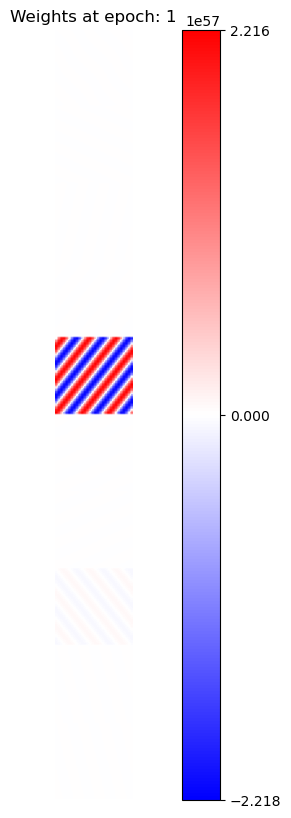

In [7]:


# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# hps
n_epochs = 1
n_units = 10
batch_size = 100

model = BCM_Model(n_in, n_units)
#model = BCM_Model_Squadrani(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch)
        draw_weights(model.weights)


### Visual Analysis

#### Selectivity

In [9]:
img = np.array(model.selectivity)
img =img.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

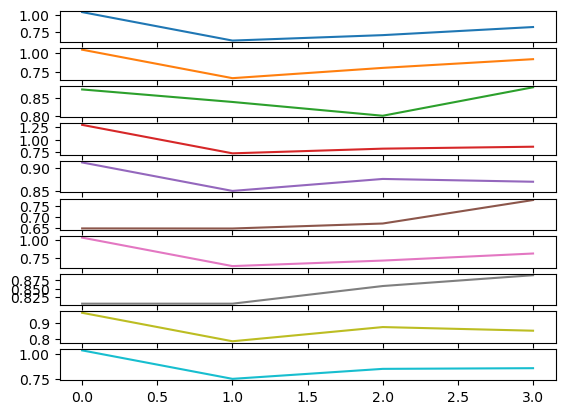

In [10]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': img[i,:] for i in range(n_units)})
df.plot(subplots=True, legend=False)

#### Threshold

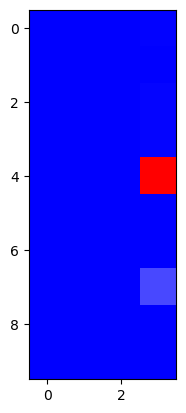

In [11]:
img = np.array(model.threshold_trace)
img = img.T
plt.imshow(img,cmap='bwr')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

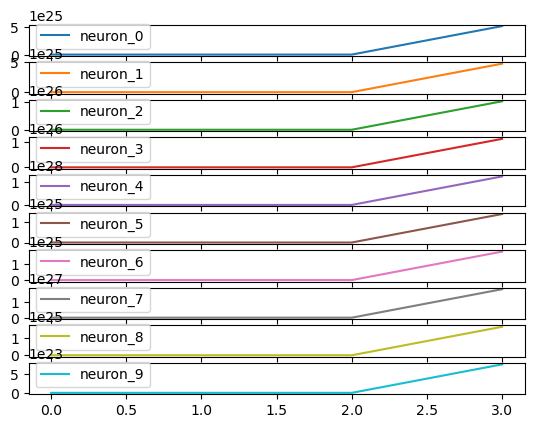

In [12]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': img[i, :] for i in range(n_units)})
df.plot(subplots=True)

#### Activations

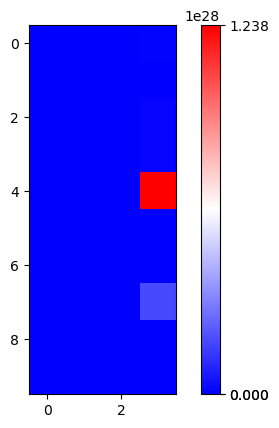

In [13]:
y = np.array(model.activations)
plt.imshow(y.T,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])